In [60]:
#!pip install matplotlib
# !pip install tifffile
# !pip install opencv-python
# !pip install scipy

  Obtaining dependency information for scipy from https://files.pythonhosted.org/packages/89/bb/80c9c98d887c855710fd31fc5ae5574133e98203b3475b07579251803662/scipy-1.14.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 MB 55.1 MB/s eta 0:00:000m eta 0:00:010:00:01


In [48]:
import numpy as np
import matplotlib.pyplot as plt
import cupy as cp  # For GPU acceleration
import tifffile
import cv2

In [13]:
volume = tifffile.imread('fused_512_cube_volume.tif')

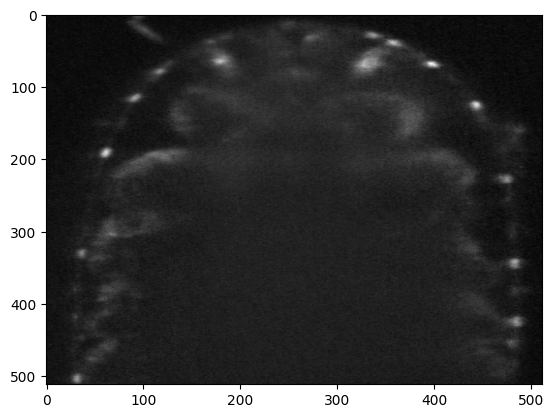

In [39]:
plt.imshow(volume[300,:,:], cmap='gray', aspect='auto')
plt.show()

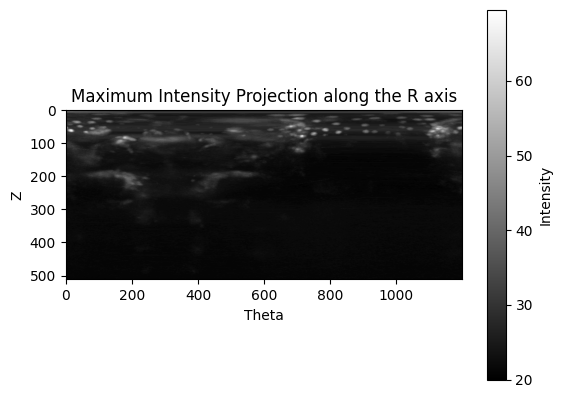

In [58]:
# Assuming volume is a 3D NumPy array of shape (depth, height, width)
# Example volume data
depth, height, width = 512, 512, 512
# volume = np.random.rand(depth, height, width)

# Define the cylindrical projection parameters
r_dim = 250  # This is the fixed radius for the projection
theta_dim = 600
z_dim = volume.shape[0]

# Create grids for cylindrical coordinates
theta, z = np.meshgrid(
    np.linspace(0, 2 * np.pi, theta_dim),
    np.arange(z_dim),
    indexing='ij'
)

# Convert cylindrical coordinates to Cartesian coordinates for all 'r'
max_r = min(volume.shape[1] // 2, volume.shape[2] // 2)
r_values = np.arange(max_r)
X = (r_values[:, np.newaxis, np.newaxis] * np.cos(theta[np.newaxis, :, :])).astype(int) + volume.shape[1] // 2
Z = (r_values[:, np.newaxis, np.newaxis] * np.sin(theta[np.newaxis, :, :])).astype(int) + volume.shape[2] // 2

# Clip coordinates to be within the volume dimensions
X = np.clip(X, 0, volume.shape[1] - 1)
Z = np.clip(Z, 0, volume.shape[2] - 1)

# Compute the MIP along the 'r' axis
mip = np.zeros((theta_dim, z_dim))

depth = np.arange(150)

for t_idx in range(theta_dim):
    for z_idx in range(z_dim):
        current_column = volume[Z[depth, t_idx, z_idx], z_idx, X[depth, t_idx, z_idx]]
        mip[t_idx, z_idx] = np.max(current_column)

image=mip.T
# Scale factor along the X-axis
scale_x = 2  # For example, to increase the width by 50%

# Calculate new dimensions
new_width = int(image.shape[1] * scale_x)
new_height = image.shape[0]  # Height remains the same

# Resize the image
resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)

# Convert BGR to RGB for displaying using matplotlib
# resized_image_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)


# Display the result using matplotlib
plt.imshow(resized_image, cmap='gray')
plt.xlabel('Theta')
plt.ylabel('Z')
plt.title('Maximum Intensity Projection along the R axis')
plt.colorbar(label='Intensity')
plt.show()

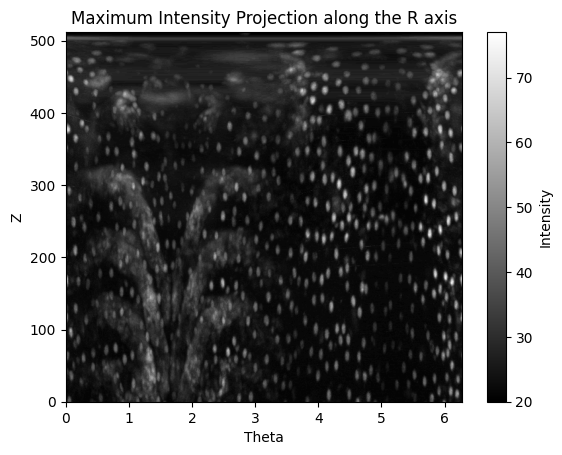

In [ ]:
# Display the result using matplotlib
plt.imshow(mip.T, cmap='gray', aspect='auto', extent=[0, 2 * np.pi, 0, z_dim])
plt.xlabel('Theta')
plt.ylabel('Z')
plt.title('Maximum Intensity Projection along the R axis')
plt.colorbar(label='Intensity')
plt.show()